In [12]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

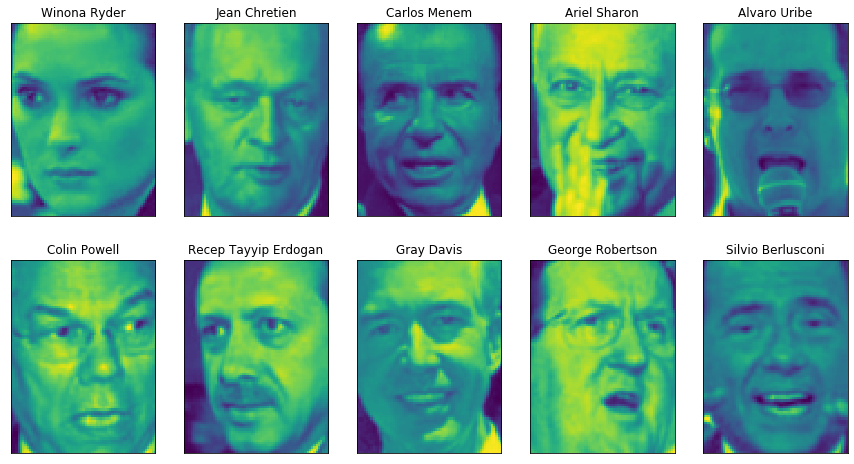

In [7]:

from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

There are 3,023 images, each 87×65 pixels large, belonging to 62 different people:

In [8]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


The dataset is a bit skewed, however, containing a lot of images of George W. Bush
and Colin Powell, as you can see here:

In [13]:
# count how often each target appears
counts = np.bincount(people.target)

# print counts next to target names
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end=' ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39 Alvaro Uribe               35 Amelie Mauresmo            21 
Andre Agassi               36 Angelina Jolie             20 Ariel Sharon               77 
Arnold Schwarzenegger      42 Atal Bihari Vajpayee       24 Bill Clinton               29 
Carlos Menem               21 Colin Powell              236 David Beckham              31 
Donald Rumsfeld           121 George Robertson           22 George W Bush             530 
Gerhard Schroeder         109 Gloria Macapagal Arroyo    44 Gray Davis                 26 
Guillermo Coria            30 Hamid Karzai               22 Hans Blix                  39 
Hugo Chavez                71 Igor Ivanov                20 Jack Straw                 28 
Jacques Chirac             52 Jean Chretien              55 Jennifer Aniston           21 
Jennifer Capriati          42 Jennifer Lopez             21 Jeremy Greenstock          24 
Jiang Zemin                20 John Ashcroft              53 John Negroponte            31 

To make the data less skewed, we will only take up to 50 images of each person
(otherwise, the feature extraction would be overwhelmed by the likelihood of George
W. Bush):

In [14]:
mask = np.zeros(people.target.shape, dtype=np.bool)

for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

A simple solution is to use a one-nearest-neighbor classifier that looks for the most
similar face image to the face you are classifying. This classifier could in principle
work with only a single training example per class. Let’s take a look at how well
KNeighborsClassifier does here:

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
X_people, y_people, stratify=y_people, random_state=0)

# build a KNeighborsClassifier using one neighbor
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.23


We obtain an accuracy of 23%, which is not actually that bad for a 62-class classification
problem (random guessing would give you around 1/62 = 1.5% accuracy), but
is also not great. We only correctly identify a person every fourth time.

This is where PCA comes in. Computing distances in the original pixel space is quite
a bad way to measure similarity between faces. When using a pixel representation to
compare two images, we compare the grayscale value of each individual pixel to the
value of the pixel in the corresponding position in the other image. This representation
is quite different from how humans would interpret the image of a face, and it is
hard to capture the facial features using this raw representation. For example, using
pixel distances means that shifting a face by one pixel to the right corresponds to a
drastic change, with a completely different representation. We hope that using distances
along principal components can improve our accuracy. Here, we enable the
whitening option of PCA, which rescales the principal components to have the same
scale. This is the same as using StandardScaler after the transformation. Reusing the
data from Figure 3-3 again, whitening corresponds to not only rotating the data, but
also rescaling it so that the center panel is a circle instead of an ellipse

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1547, 100)


Now, we can use
the new representation to classify our images using a one-nearest-neighbors classifier:

In [19]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.31


Our accuracy improved quite significantly, from 26.6% to 35.7%, confirming our
intuition that the principal components might provide a better representation of the
data.

For image data, we can also easily visualize the principal components that are found.
Remember that components correspond to directions in the input space. The input
space here is 50×37-pixel grayscale images, so directions within this space are also
50×37-pixel grayscale images.
Let’s look at the first couple of principal components

In [ ]:
print("pca.components_.shape: {}".format(pca.components_.shape))

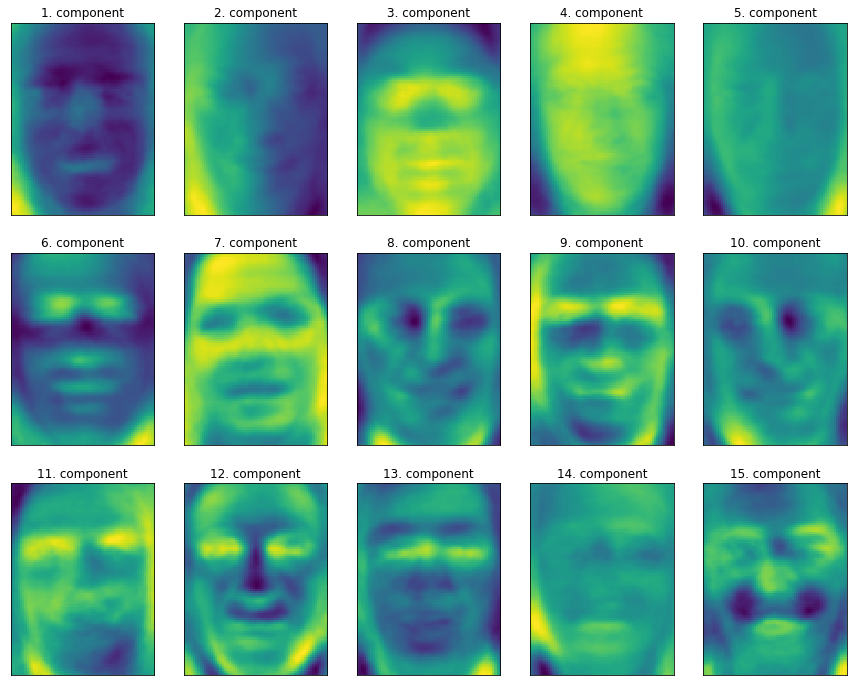

In [20]:
fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                                        subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape),
                cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))